**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ seaborn 0.9.0

# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Это задание посвящено линейной регрессии. На примере прогнозирования роста человека по его весу Вы увидите, какая математика за этим стоит, а заодно познакомитесь с основными библиотеками Python, полезными в машинном обучении.

**Материалы**

- Лекции по линейным моделям и градиентному спуску
- [Документация](http://docs.scipy.org/doc/) по библиотекам NumPy и SciPy
- [Документация](http://matplotlib.org/) по библиотеке Matplotlib 
- [Документация](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) по библиотеке Pandas
- [Pandas Cheat Sheet](http://www.analyticsvidhya.com/blog/2015/07/11-steps-perform-data-analysis-pandas-python/)
- [Документация](http://stanford.edu/~mwaskom/software/seaborn/) по библиотеке Seaborn 

## Задача 1. Первичный анализ данных c Pandas

В этой задаче мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1].** Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar, minimize
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [110]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

<AxesSubplot:title={'center':'Height (inch.) distribution'}, ylabel='Frequency'>

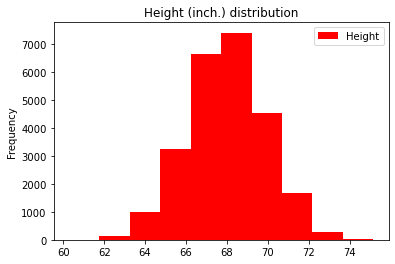

In [111]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]**. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.

In [112]:
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


<AxesSubplot:title={'center':'Weight (inch.) distribution'}, ylabel='Frequency'>

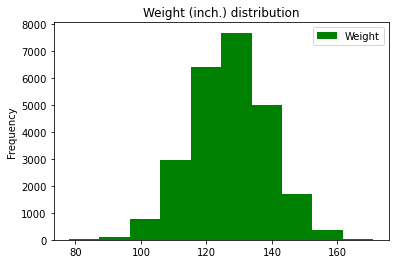

In [113]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Weight (inch.) distribution')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [114]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [115]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

**[3].** Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.

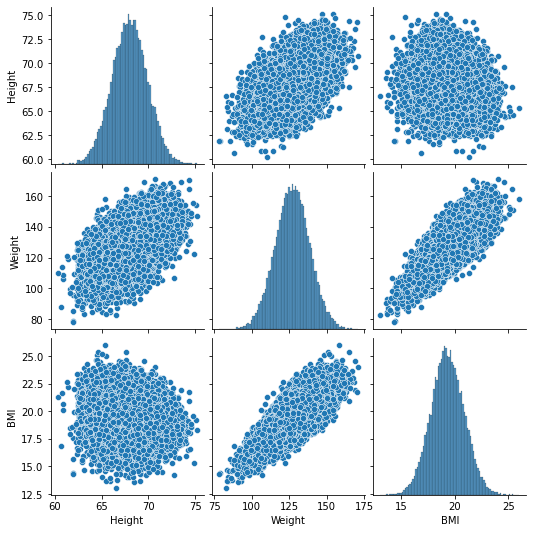

In [116]:
sns.pairplot(data)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

**[4]**. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».

In [117]:
def weight_category(weight):
    if weight < 120:
        return 1
    elif weight > 150:
        return 2
    else:
        return 3

data['weight_cat'] = data['Weight'].apply(weight_category)

[Text(0.5, 0, 'Весовая категория'), Text(0, 0.5, 'Рост')]

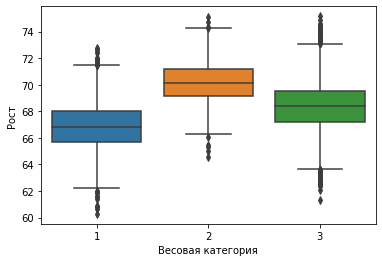

In [118]:
a = sns.boxplot(data=data, x='weight_cat', y='Height')
a.set(xlabel="Весовая категория", ylabel="Рост")

**[5].** Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.

<AxesSubplot:title={'center':'Weight_cat(Height) dependence'}, xlabel='Weight', ylabel='Height'>

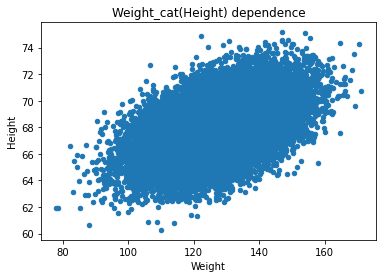

In [119]:
data.plot(x='Weight', y='Height', kind='scatter', title='Weight_cat(Height) dependence')

## Задача 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6].** Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [120]:
def mserror(w0, w1, y, x):
    return np.sum((y - w0 - w1 * x) ** 2)

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

**[7].** Проведите на графике из п. 5 Задачи 1 две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. Используйте метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy. Подпишите оси и график.

<AxesSubplot:title={'center':'Weight_cat(Height) dependence'}, xlabel='Weight', ylabel='Height'>

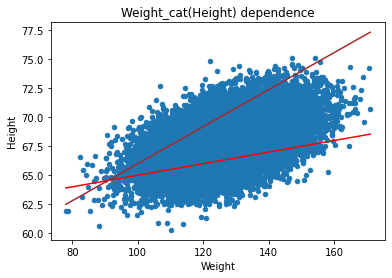

In [121]:
w_min = min(data['Weight'])
w_max = max(data['Weight'])
xs = np.linspace(w_min, w_max, 100)

w0, w1 = 60, 0.05
ys1 = w0 + w1 * xs
w0, w1 = 50, 0.16
ys2 = w0 + w1 * xs

fig, ax = plt.subplots()
ax.plot(xs, ys1, 'r')
ax.plot(xs, ys2, 'brown')
data.plot(x='Weight', y='Height', kind='scatter', title='Weight_cat(Height) dependence', ax=ax)

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

**[8].** Постройте график зависимости функции ошибки, посчитанной в п. 6, от параметра $w_1$ при $w_0$ = 50. Подпишите оси и график.

Text(0, 0.5, 'w1')

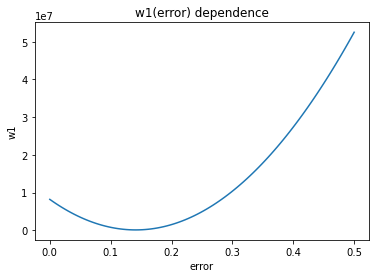

In [122]:
w0, w1s = 50, np.linspace(0, 0.5, 100)
errors = [mserror(w0, w1, data['Height'], data['Weight']) for w1 in w1s]
plt.plot(w1s, errors)
plt.title("w1(error) dependence")
plt.xlabel("error")
plt.ylabel("w1")

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

**[9].** С помощью метода *minimize_scalar* из *scipy.optimize* найдите минимум функции, определенной в п. 6, для значений параметра  $w_1$ в диапазоне [-5,5]. Проведите на графике из п. 5 Задачи 1 прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное в п. 8 оптимальное значение параметра $w_1$. 

In [123]:
w1_opt = minimize_scalar(lambda w1: mserror(w0, w1, data['Height'], data['Weight']), bounds=[-5, 5]).x

<AxesSubplot:title={'center':'Weight_cat(Height) dependence'}, xlabel='Weight', ylabel='Height'>

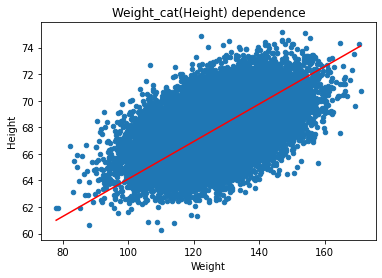

In [124]:
w0, w1 = 50, w1_opt
ys = w0 + w1 * xs

fig, ax = plt.subplots()
ax.plot(xs, ys, 'r')
data.plot(x='Weight', y='Height', kind='scatter', title='Weight_cat(Height) dependence', ax=ax)

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделяют 2 или, соответственно, 3 главные компоненты (метод главных компонент) и отображают данные на плоскости или в объеме. 

Посмотрим, как в Python рисовать 3D картинки, на примере отображения функции $z(x,y) = sin(\sqrt{x^2+y^2})$ для значений $x$ и $y$ из интервала [-5,5] c шагом 0.25.

In [125]:
from mpl_toolkits.mplot3d import Axes3D

Создаем объекты типа matplotlib.figure.Figure (рисунок) и  matplotlib.axes._subplots.Axes3DSubplot (ось). 

/var/folders/86/l0bxfqt113d8c11w_f246q500000gn/T/ipykernel_12220/1709720375.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d') # get current axis


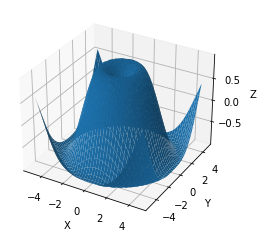

In [126]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

**[10].** Постройте 3D-график зависимости функции ошибки, посчитанной в п.6 от параметров $w_0$ и $w_1$. Подпишите ось $x$ меткой «Intercept», ось $y$ – меткой «Slope», a ось $z$ – меткой «Error».

/var/folders/86/l0bxfqt113d8c11w_f246q500000gn/T/ipykernel_12220/821987711.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d') # get current axis


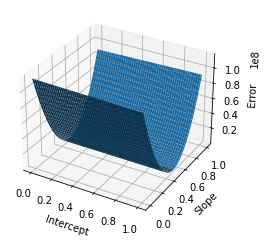

In [127]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

w0s = np.linspace(0, 1, 100)
w1s = np.linspace(0, 1, 100)
X, Y = np.meshgrid(w0s, w1s)
errors = np.array([[mserror(w0, w1, data['Height'], data['Weight']) for w0 in w0s] for w1 in w1s])

surf = ax.plot_surface(X, Y, errors)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

**[11].** С помощью метода *minimize* из scipy.optimize найдите минимум функции, определенной в п. 6, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используйте метод оптимизации L-BFGS-B (аргумент method метода minimize). Проведите на графике из п. 5 Задачи 1 прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.

In [128]:
fun = lambda var: mserror(*var, data['Height'], data['Weight'])
ans = minimize(fun, x0=(0, 0), method='L-BFGS-B', bounds=((-100, 100), (-5, 5)))
w0, w1 = ans.x

<AxesSubplot:title={'center':'minimized'}, xlabel='Weight', ylabel='Height'>

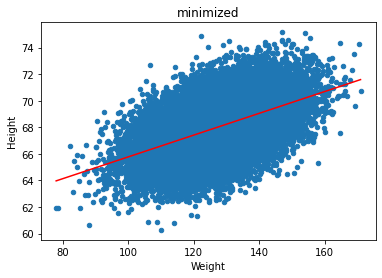

In [129]:
ys = w0 + w1 * xs

fig, ax = plt.subplots()
ax.set_title('minimized')
ax.plot(xs, ys, 'r')
data.plot(x='Weight', y='Height', kind='scatter', ax=ax)

## Оценка работы

- Выполняется ли тетрадка IPython без ошибок?
- Верно ли отображена гистограмма распределения роста из п. 2? Правильно ли оформлены подписи?
- Верно ли отображены попарные зависимости признаков из п. 3? Правильно ли оформлены подписи?
- Верно ли отображена зависимость роста от весовой категории из п. 4? Правильно ли оформлены подписи?
- Верно ли отображен scatter plot роста от веса из п. 5? Правильно ли оформлены подписи?
- Правильно ли реализована функция подсчета квадратичной ошибки из п. 6?
- Правильно ли нарисован график из п. 7? Правильно ли оформлены подписи?
- Правильно ли нарисован график из п. 8? Правильно ли оформлены подписи?
- Правильно ли используется метод minimize\_scalar из scipy.optimize? Правильно ли нарисован график из п. 9? Правильно ли оформлены подписи?
- Правильно ли нарисован 3D-график из п. 10? Правильно ли оформлены подписи?
- Правильно ли используется метод minimize из scipy.optimize? Правильно ли нарисован график из п. 11? Правильно ли оформлены подписи?